## Online retail RFM

In [2]:
# import required libraries for dataframe and visualization

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

# import required libraries for clustering
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

In [3]:
# Reading the data on which analysis needs to be done

df = pd.read_csv('C://OnlineRetailSecond.csv', sep=",", encoding="ISO-8859-1", header=0)
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01-12-2010 08:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01-12-2010 08:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,01-12-2010 08:26,3.39,17850.0,United Kingdom


<a id="2"></a> <br>
## Step 2 : Data Cleansing

In [4]:
# What percent of each attribute is null?

round(100*(df.isnull().sum())/len(df), 2)

InvoiceNo       0.00
StockCode       0.00
Description     0.27
Quantity        0.00
InvoiceDate     0.00
UnitPrice       0.00
CustomerID     24.93
Country         0.00
dtype: float64

In [5]:
# Droping rows having missing values

df = df.dropna()
df.shape

(406829, 8)

In [6]:
# Changing the datatype of Customer Id as per Business understanding

#df['CustomerID'] = df['CustomerID'].astype(str)


In [7]:
# customer id has floating values; convert them to int

df['CustomerID'] = df['CustomerID'].astype('int64')

<a id="3"></a> <br>
## Step 3 : Data Preparation

#### We are going to analysis the Customers based on below 3 factors:
- R (Recency): Number of days since last purchase
- F (Frequency): Number of tracsactions
- M (Monetary): Total amount of transactions (revenue contributed)

In [8]:
#Add column "total" to know money spent

df['Total'] = df['Quantity']*df['UnitPrice']

In [9]:
#Convert the string date field to datetime

df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

In [10]:
# Compute the maximum date to know the last transaction date

max_date = max(df['InvoiceDate'])

In [11]:
#Create RFM Modelling scores for each customer

rfm = df.groupby('CustomerID').agg({'InvoiceDate': lambda x: (max_date - x.max()).days, 'InvoiceNo': lambda x: len(x), 'Total': lambda x: x.sum()})

In [12]:
#Convert Invoice Date into type int
rfm['InvoiceDate'] = rfm['InvoiceDate'].astype(int)

In [13]:
#Rename column names to Recency, Frequency and Monetary

rfm.rename(columns={'InvoiceDate': 'Recency', 'InvoiceNo': 'Frequency', 'Total': 'Monetary'}, inplace=True)
rfm.reset_index().head()

,CustomerID,Recency,Frequency,Monetary
0,12346,326,2,0.00
1,12347,40,182,4310.00
2,12348,76,31,1797.24
3,12349,19,73,1757.55
4,12350,311,17,334.40


In [14]:
#Split into four segments using quantiles

quantiles = rfm.quantile(q=[0.25,0.5,0.75])

#Coverting dataframe to a dictionary(matrixlike)
quantiles = quantiles.to_dict()
quantiles

{'Recency': {0.25: 20.0, 0.5: 57.0, 0.75: 152.0},
 'Frequency': {0.25: 17.0, 0.5: 42.0, 0.75: 102.0},
 'Monetary': {0.25: 293.36249999999995,
  0.5: 648.0750000000002,
  0.75: 1611.725}}

In [15]:
#Ranking the attributes using quantiles

def Recency(x,p,d):
    if x <= d[p][0.25]:
        return 1
    elif x <= d[p][0.50]:
        return 2
    elif x <= d[p][0.75]: 
        return 3
    else:
        return 4
    
def Freq_Mon(x,p,d):
    if x <= d[p][0.25]:
        return 4
    elif x <= d[p][0.50]:
        return 3
    elif x <= d[p][0.75]: 
        return 2
    else:
        return 1

In [16]:
#Calculate Add R, F and M segment value columns in the existing dataset to show R, F and M segment values

rfm['R'] = rfm['Recency'].apply(Recency, args=('Recency',quantiles,))
rfm['F'] = rfm['Frequency'].apply(Freq_Mon, args=('Frequency',quantiles,))
rfm['M'] = rfm['Monetary'].apply(Freq_Mon, args=('Monetary',quantiles,))
rfm.head()

,Recency,Frequency,Monetary,R,F,M
CustomerID,,,,,,
12346,326,2,0.00,4,4,4
12347,40,182,4310.00,2,1,1
12348,76,31,1797.24,3,3,1
12349,19,73,1757.55,1,2,1
12350,311,17,334.40,4,4,3


In [17]:
#Calculate and Add RFMScore value column showing total sum of RFMGroup values

rfm['TotalRank'] = rfm[['R', 'F', 'M']].sum(axis = 1)
rfm.head()

,Recency,Frequency,Monetary,R,F,M,TotalRank
CustomerID,,,,,,,
12346,326,2,0.00,4,4,4,12
12347,40,182,4310.00,2,1,1,4
12348,76,31,1797.24,3,3,1,7
12349,19,73,1757.55,1,2,1,4
12350,311,17,334.40,4,4,3,11


In [18]:
#Assign Loyalty Level to each customer

Rank_Label = ['Icon', 'Elite', 'Select', 'Rookie']
Score = pd.qcut(rfm.TotalRank, q = 4, labels = Rank_Label)
rfm['Category'] = Score.values
rfm.reset_index().head()

,CustomerID,Recency,Frequency,Monetary,R,F,M,TotalRank,Category
0,12346,326,2,0.00,4,4,4,12,Rookie
1,12347,40,182,4310.00,2,1,1,4,Icon
2,12348,76,31,1797.24,3,3,1,7,Elite
3,12349,19,73,1757.55,1,2,1,4,Icon
4,12350,311,17,334.40,4,4,3,11,Rookie


## Kmeans

In [19]:
#Handle negative and zero values so as to handle infinite numbers during log transformation

def NumHandler(num):
    if num <= 0:
        return 1
    else:
        return num
    
#Apply handle_neg_n_zero function to Recency and Monetary columns

rfm['Recency'] = [NumHandler(x) for x in rfm.Recency]
rfm['Monetary'] = [NumHandler(x) for x in rfm.Monetary]

#Perform Log transformation to bring data into normal or near normal distribution

Normalize = rfm[['Recency', 'Frequency', 'Monetary']].apply(np.log, axis = 1).round(3)

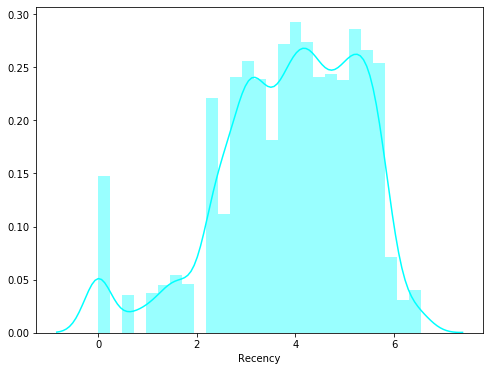

In [20]:
#Data distribution after data normalization for Recency

plt.figure(figsize=(8,6))
Recency_Plot = Normalize['Recency']
ax = sns.distplot(Recency_Plot, color = 'cyan')

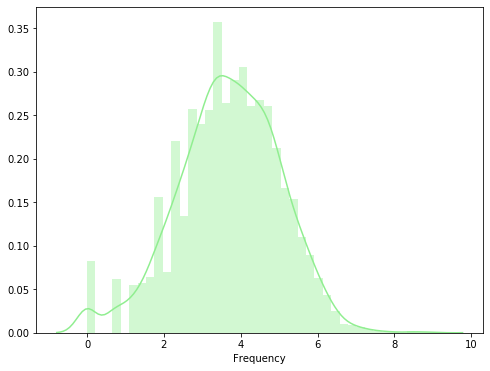

In [21]:
#Data distribution after data normalization for Frequency

plt.figure(figsize=(8,6))
Frequency_Plot = Normalize['Frequency']
ax = sns.distplot(Frequency_Plot, color = 'lightgreen')

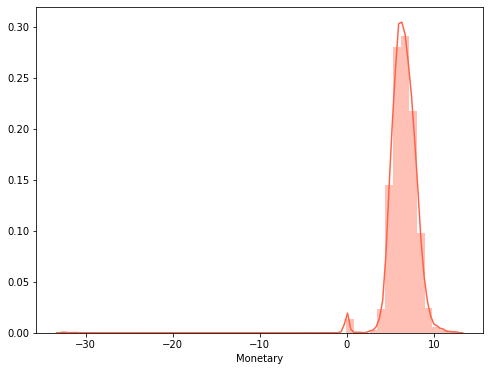

In [22]:
#Data distribution after data normalization for Monetary
plt.figure(figsize=(8,6))
Monetary_Plot = Normalize['Monetary']
ax = sns.distplot(Monetary_Plot, color = 'tomato')

### Rescaling the Attributes

It is extremely important to rescale the variables so that they have a comparable scale.|
There are two common ways of rescaling:

1. Min-Max scaling 
2. Standardisation (mean-0, sigma-1) 

Here, we will use Standardisation Scaling.

In [23]:
# Initiate Scaler
scaler = StandardScaler()

# Fit_transform
rfm_scaled = scaler.fit_transform(Normalize)

In [24]:
rfm_scaled = pd.DataFrame(rfm_scaled, index = rfm.index, columns = Normalize.columns)
#rfm_scaled.head()


## Building the Model

### K-Means Clustering

K-means clustering is one of the simplest and popular unsupervised machine learning algorithms.<br>

The algorithm works as follows:

- First we initialize k points, called means, randomly.
- We categorize each item to its closest mean and we update the mean’s coordinates, which are the averages of the items categorized in that mean so far.
- We repeat the process for a given number of iterations and at the end, we have our clusters.

### Finding the Optimal Number of Clusters

#### Elbow Curve to get the right number of Clusters
A fundamental step for any unsupervised algorithm is to determine the optimal number of clusters into which the data may be clustered. The Elbow Method is one of the most popular methods to determine this optimal value of k.

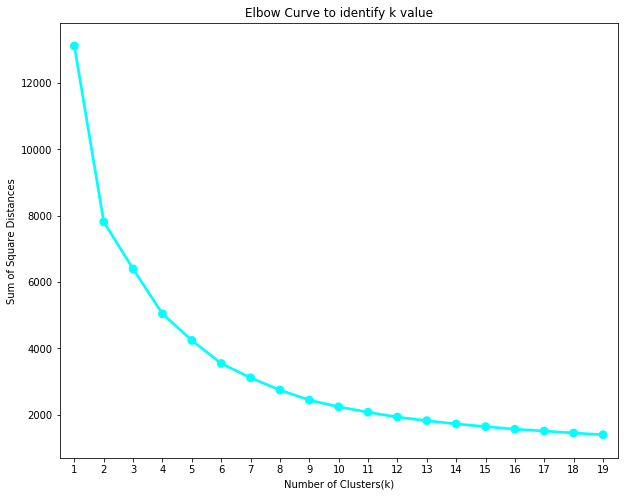

In [25]:
# Elbow-curve to find K----Sum of Squared Distance


ssd = {} #Initialize an empty dictionary for distance values
for k in range(1,20):
    KM = KMeans(n_clusters= k, init= 'k-means++', max_iter= 100)
    KM = KM.fit(rfm_scaled)

    ssd[k] = KM.inertia_    

#Plot the graph for the sum of square distance values and Number of Clusters
plt.figure(figsize=(10,8))
sns.pointplot(x = list(ssd.keys()), y = list(ssd.values()), color='cyan')
plt.xlabel('Number of Clusters(k)')
plt.ylabel('Sum of Square Distances')
plt.title('Elbow Curve to identify k value')
plt.show()

In [26]:
#Perform K-Mean Clustering or build the K-Means clustering model

Cluster = KMeans(n_clusters= 3, init= 'k-means++', max_iter= 1000)
Cluster.fit(rfm_scaled)

#Find the clusters for the observation given in the dataset
rfm['Cluster'] = Cluster.labels_
rfm.head()


,Recency,Frequency,Monetary,R,F,M,TotalRank,Category,Cluster
CustomerID,,,,,,,,,
12346,326,2,1.00,4,4,4,12,Rookie,1
12347,40,182,4310.00,2,1,1,4,Icon,2
12348,76,31,1797.24,3,3,1,7,Elite,0
12349,19,73,1757.55,1,2,1,4,Icon,2
12350,311,17,334.40,4,4,3,11,Rookie,1


<Figure size 504x504 with 0 Axes>

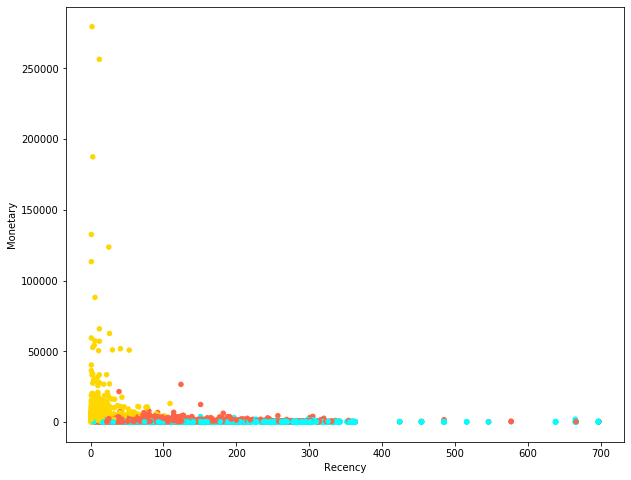

In [28]:
from matplotlib import pyplot as plt
plt.figure(figsize=(7,7))

##Scatter Plot Frequency Vs Recency

Colors = ["tomato", "cyan", "gold"]
rfm['Color'] = rfm['Cluster'].map(lambda f: Colors[f])
ax = rfm.plot(kind="scatter", x="Recency", y="Monetary", figsize=(10,8), c = rfm['Color'])

In [27]:
rfm[:10]

,Recency,Frequency,Monetary,R,F,M,TotalRank,Category,Cluster,Color
CustomerID,,,,,,,,,,
12346,326,2,1.00,4,4,4,12,Rookie,2,gold
12347,40,182,4310.00,2,1,1,4,Icon,1,cyan
12348,76,31,1797.24,3,3,1,7,Elite,0,tomato
12349,19,73,1757.55,1,2,1,4,Icon,1,cyan
12350,311,17,334.40,4,4,3,11,Rookie,2,gold
12352,73,95,1545.41,3,2,2,7,Elite,0,tomato
12353,204,4,89.00,4,4,4,12,Rookie,2,gold
12354,233,58,1079.40,4,2,2,8,Elite,0,tomato
12355,96,13,459.40,3,4,3,10,Select,2,gold


In [28]:
rfm.columns

Index(['Recency', 'Frequency', 'Monetary', 'R', 'F', 'M', 'TotalRank',
       'Category', 'Cluster', 'Color'],
      dtype='object')

In [29]:
# Merged rfm with main dataframe

df_NEW = pd.merge(df, rfm, on='CustomerID', how='inner')
df_NEW.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Total,Recency,Frequency,Monetary,R,F,M,TotalRank,Category,Cluster,Color
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-01-12 08:26:00,2.55,17850,United Kingdom,15.30,69,312,5288.63,3,1,1,5,Icon,1,cyan
1,536365,71053,WHITE METAL LANTERN,6,2010-01-12 08:26:00,3.39,17850,United Kingdom,20.34,69,312,5288.63,3,1,1,5,Icon,1,cyan
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-01-12 08:26:00,2.75,17850,United Kingdom,22.00,69,312,5288.63,3,1,1,5,Icon,1,cyan
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-01-12 08:26:00,3.39,17850,United Kingdom,20.34,69,312,5288.63,3,1,1,5,Icon,1,cyan
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-01-12 08:26:00,3.39,17850,United Kingdom,20.34,69,312,5288.63,3,1,1,5,Icon,1,cyan


In [30]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Total
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-01-12 08:26:00,2.55,17850,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-01-12 08:26:00,3.39,17850,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-01-12 08:26:00,2.75,17850,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-01-12 08:26:00,3.39,17850,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-01-12 08:26:00,3.39,17850,United Kingdom,20.34


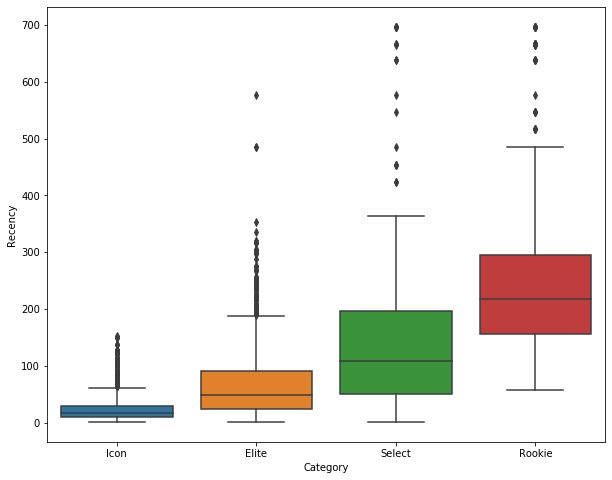

In [31]:
# Box plot to visualize Cluster vs Recency

plt.figure(figsize=(10,8))
sns.boxplot(x='Category', y='Recency', data=rfm)

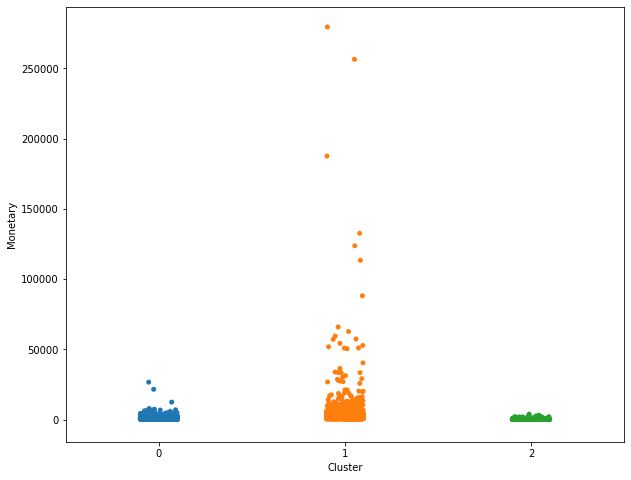

In [32]:
# Box plot to visualize Cluster vs Monetary

plt.figure(figsize=(10,8))
sns.stripplot(x='Cluster', y='Monetary', data=rfm)

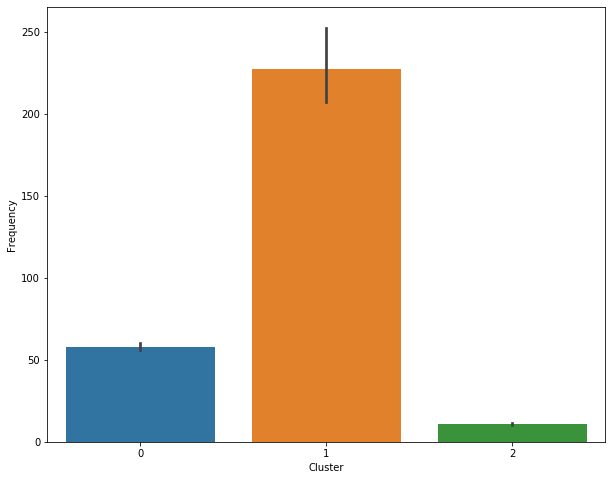

In [33]:
# Box plot to visualize Cluster  vs Frequency

plt.figure(figsize=(10,8))
sns.barplot(x='Cluster', y='Frequency', data=rfm)

In [34]:
import pandas as pd
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
from matplotlib import pyplot as plt

In [35]:
df_NEW.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Total,Recency,Frequency,Monetary,R,F,M,TotalRank,Category,Cluster,Color
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-01-12 08:26:00,2.55,17850,United Kingdom,15.30,69,312,5288.63,3,1,1,5,Icon,1,cyan
1,536365,71053,WHITE METAL LANTERN,6,2010-01-12 08:26:00,3.39,17850,United Kingdom,20.34,69,312,5288.63,3,1,1,5,Icon,1,cyan
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-01-12 08:26:00,2.75,17850,United Kingdom,22.00,69,312,5288.63,3,1,1,5,Icon,1,cyan
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-01-12 08:26:00,3.39,17850,United Kingdom,20.34,69,312,5288.63,3,1,1,5,Icon,1,cyan
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-01-12 08:26:00,3.39,17850,United Kingdom,20.34,69,312,5288.63,3,1,1,5,Icon,1,cyan


In [36]:
basket_icon = (df_NEW[df_NEW['Category'] == 'Icon']
          .groupby(['InvoiceNo', 'Description'])['Quantity']
          .sum().unstack().reset_index().fillna(0)
          .set_index('InvoiceNo'))

In [37]:
#CONVERTING TO 0's AND 1's

def encode_units(x):
    if x <= 0:
        return 0
    if x >= 1:
        return 1
basket_sets_icon = basket_icon.applymap(encode_units)
basket_sets_icon.drop('POSTAGE', inplace=True, axis=1)

In [38]:
#GENERATION OF FREQUENT ITEMSET

frequent_itemsets_icon = apriori(basket_sets_icon, min_support=0.025, use_colnames=True)
rules = association_rules(frequent_itemsets_icon ,metric="lift", min_threshold=1)

In [39]:
rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(ALARM CLOCK BAKELIKE RED ),(ALARM CLOCK BAKELIKE GREEN),0.047728,0.044425,0.030336,0.635593,14.307117,0.028215,2.622276
1,(ALARM CLOCK BAKELIKE GREEN),(ALARM CLOCK BAKELIKE RED ),0.044425,0.047728,0.030336,0.682853,14.307117,0.028215,3.002618
2,(ROSES REGENCY TEACUP AND SAUCER ),(GREEN REGENCY TEACUP AND SAUCER),0.038156,0.032291,0.026021,0.681979,21.119986,0.024789,3.042908
3,(GREEN REGENCY TEACUP AND SAUCER),(ROSES REGENCY TEACUP AND SAUCER ),0.032291,0.038156,0.026021,0.805846,21.119986,0.024789,4.954016
4,(JUMBO BAG RED RETROSPOT),(JUMBO BAG PINK POLKADOT),0.086086,0.047256,0.030808,0.357870,7.572958,0.026739,1.483724
5,(JUMBO BAG PINK POLKADOT),(JUMBO BAG RED RETROSPOT),0.047256,0.086086,0.030808,0.651926,7.572958,0.026739,2.625630
6,(JUMBO BAG RED RETROSPOT),(JUMBO STORAGE BAG SUKI),0.086086,0.043481,0.025684,0.298356,6.861714,0.021941,1.363253
7,(JUMBO STORAGE BAG SUKI),(JUMBO BAG RED RETROSPOT),0.043481,0.086086,0.025684,0.590698,6.861714,0.021941,2.232858
8,(LUNCH BAG BLACK SKULL.),(LUNCH BAG PINK POLKADOT),0.057975,0.049751,0.026291,0.453488,9.115239,0.023407,1.738754
9,(LUNCH BAG PINK POLKADOT),(LUNCH BAG BLACK SKULL.),0.049751,0.057975,0.026291,0.528455,9.115239,0.023407,1.997743


In [40]:
df['monthname'] = df['InvoiceDate'].dt.month_name()

r = df[df['Description'] == "RABBIT NIGHT LIGHT"].groupby(['monthname'])['UnitPrice'].unique()
r

monthname
April                    [1.79, 2.08]
August                   [2.08, 1.79]
December                 [1.79, 2.08]
February                 [2.08, 1.79]
January                  [1.79, 2.08]
July                     [2.08, 1.79]
June                     [2.08, 1.79]
March              [2.08, 4.13, 1.79]
May                [2.08, 1.79, 4.13]
November           [2.08, 1.79, 4.13]
October      [2.08, 4.13, 1.79, 1.67]
September          [2.08, 1.79, 4.13]
Name: UnitPrice, dtype: object

In [41]:
April                    [1.79, 2.08]
August                   [2.08, 1.79]
December                 [1.79, 2.08]
February                 [2.08, 1.79]
January                  [1.79, 2.08]
July                     [2.08, 1.79]
June                     [2.08, 1.79]
March              [2.08, 4.13, 1.79]
May                [2.08, 1.79, 4.13]
November           [2.08, 1.79, 4.13]
October      [2.08, 4.13, 1.79, 1.67]
September          [2.08, 1.79, 4.13]

NameError: name 'April' is not defined

In [ ]:
data = [['April',[1.79, 2.08]], ['August',[2.08, 1.79]], ['December',[1.79, 2.08]], ['February',[2.08, 1.79]], ['January',[1.79, 2.08]], ['July',[2.08, 1.79]],         ['June',[2.08, 1.79]],['March',[2.08, 4.13, 1.79]],['May',[2.08, 1.79, 4.13]],['November',[2.08, 1.79, 4.13]], ['October',[2.08, 4.13, 1.79, 1.67]], ['September',[2.08, 1.79, 4.13]]]  
temp = pd.DataFrame(data, columns = ['Month', 'Price'])

In [ ]:
temp

In [ ]:
#boxplot = temp.boxplot(column=['Monthu', 'Priceu'])
temp.plot(kind = 'box',color = 'aqua', figsize=(12,7))